# Outline
## Meta-predict
## Descrip_predict

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import torch.nn as nn
import torch.nn.functional as F
device='cuda'
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import time
import jieba
import random
import json
import ast

In [2]:
df=pd.read_csv('broaden_data.csv')
df.columns

Index(['num', 'name', 'price', 'sales', 'shop_name', 'shop_link',
       'product_link', 'image_link', 'shipping_insurance', 'free_shipping',
       'province', 'city', 'sales_category', 'merged_sales_category', 'words',
       'SN', 'product_discrip', 'mkt_service', 'mailing', 'src_list',
       'product_detail', '品牌', '尺码', '图案', '领型', '颜色', '袖型', '填充物', '细分风格',
       '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '男装-穿着方式', '充绒量', '含绒量', '穿搭方式',
       '绒子含量', '货号', '上市年份季节', '销售渠道类型', '材质成分', 'size_count', 'color_count'],
      dtype='object')

## Meta-predict

In [3]:
df1=df.loc[:,['merged_sales_category','price','shipping_insurance','free_shipping','city','product_discrip', 'mkt_service', 'mailing','图案', '领型', '袖型', '填充物', '细分风格',
       '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '穿搭方式','上市年份季节', '销售渠道类型','size_count', 'color_count']]
df1.head()

,merged_sales_category,price,shipping_insurance,free_shipping,city,product_discrip,mkt_service,mailing,图案,领型,...,基础风格,厚薄,适用场景,衣长,适用对象,穿搭方式,上市年份季节,销售渠道类型,size_count,color_count
0,small,399,True,True,上海,4.9,4.9,4.9,纯色,可脱卸帽,...,商务绅士,加厚,上班,中长款,中年,外穿,NaN,NaN,6,2
1,small,11800,False,True,上海,4.9,4.9,4.9,纯色,可脱卸帽,...,青春流行,NaN,其他休闲,常规款,NaN,NaN,2022年冬季,商场同款(线上线下都销售),5,2
2,small,249,False,True,泉州,4.6,4.7,4.7,其他/other,连帽,...,青春流行,加厚,其他休闲,常规款,青少年,外穿,2023年冬季,纯电商(只在线上销售),6,3
3,small,209,False,True,泉州,4.7,4.7,4.7,字母数字,无帽立领,...,青春流行,加厚,其他休闲,常规款,青少年,外穿,2023年冬季,NaN,5,14
4,mid,275,False,True,杭州,4.9,4.9,4.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


## 编码处理

由于商品详细信息中缺失值较多，我们直接用unknown表示缺失的值

In [4]:
# 对于每个类别型列
category_columns = ['图案', '领型', '袖型', '填充物', '细分风格', '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '穿搭方式', '上市年份季节', '销售渠道类型']

# 使用循环处理每一列
for col in category_columns:
    df1[col] = df1[col].fillna('Unknown')
    
for col in ['product_discrip', 'mkt_service', 'mailing','size_count','color_count']:
    df1[col] = df1[col].fillna(df1[col].median())

In [5]:
df1[category_columns]

,图案,领型,袖型,填充物,细分风格,基础风格,厚薄,适用场景,衣长,适用对象,穿搭方式,上市年份季节,销售渠道类型
0,纯色,可脱卸帽,收口袖,白鹅绒,商务休闲,商务绅士,加厚,上班,中长款,中年,外穿,Unknown,Unknown
1,纯色,可脱卸帽,Unknown,鸭绒,Unknown,青春流行,Unknown,其他休闲,常规款,Unknown,Unknown,2022年冬季,商场同款(线上线下都销售)
2,其他/other,连帽,收口袖,白鸭绒,潮,青春流行,加厚,其他休闲,常规款,青少年,外穿,2023年冬季,纯电商(只在线上销售)
3,字母数字,无帽立领,收口袖,白鸭绒,美式休闲,青春流行,加厚,其他休闲,常规款,青少年,外穿,2023年冬季,Unknown
4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,其他/other,Unknown,常规,鸭绒,Unknown,Unknown,常规,Unknown,常规,Unknown,Unknown,2023年冬季,纯电商(只在线上销售)
4390,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4391,格子,Unknown,插肩袖,鸭绒,Unknown,Unknown,常规,Unknown,中长款,Unknown,Unknown,2023年冬季,Unknown
4392,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [5]:
# 处理布尔类型数据
category_columns=category_columns+['city']
df1['shipping_insurance'] = df1['shipping_insurance'].astype(int)
df1['free_shipping'] = df1['free_shipping'].astype(int)
df1['price']=df1['price'].apply(np.log)

# 独热编码
df1 = pd.get_dummies(df1, columns=category_columns+['city']) 

# 归一化数值数据
scaler = StandardScaler()
df1[['price', 'product_discrip', 'mkt_service', 'mailing', 'size_count', 'color_count']] = scaler.fit_transform(df1[['price', 'product_discrip', 'mkt_service', 'mailing', 'size_count', 'color_count']])


# 数据集拆分
X = df1.drop('merged_sales_category', axis=1)
y = df1['merged_sales_category']

# 创建LabelEncoder对象
label_encoder = LabelEncoder()

# 将类别型标签转换为整数
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### 机器学习模型对比

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score




models = {
    "逻辑回归": LogisticRegression(),
    "决策树分类": DecisionTreeClassifier(random_state=42),
    "随机森林分类": RandomForestClassifier(random_state=42),
    "梯度提升分类": GradientBoostingClassifier(random_state=42),
    "支持向量分类（SVM）": SVC(),
    #"XGBoost": XGBClassifier(random_state=42),
    #"LightGBM": LGBMClassifier(random_state=42)
}

# 训练和评估模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - 准确率: {accuracy:.2f}")


C:\CL17189\APPS\Python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


逻辑回归 - 准确率: 0.61
决策树分类 - 准确率: 0.58
随机森林分类 - 准确率: 0.64
梯度提升分类 - 准确率: 0.65
支持向量分类（SVM） - 准确率: 0.64


In [6]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 定义自定义Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 创建Dataset实例
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

## 模型搭建

In [7]:
class Train:
    def __init__(self, train_loader, test_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        self.model_info = {
            'max_accuracy': 0,
            'model_complexity': None, # 初始化模型复杂度为空
            'convergence_speed': None, # 初始化收敛速度为空
            'training_speed': None, # 初始化训练速度为空
            'early_stop_epoch': None ,# 初始化早停轮数为空
            'generalization':None,
        }

    def train_step(self, model, criterion, optimizer, info, labels):
        """执行一个训练步骤"""
        info, labels = info.to(self.device), labels.to(self.device)
        optimizer.zero_grad()
        outputs = model(info)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        return loss.item(), outputs

    def valid_step(self, model, criterion, info, labels):
        """执行一个验证步骤"""
        info, labels = info.to(self.device), labels.to(self.device)
        outputs = model(info)
        loss = criterion(outputs, labels)
        return loss.item(), outputs

    def calculate_accuracy(self, outputs, labels):
        """计算准确率"""
        labels = labels.to(outputs.device)  # 确保labels和outputs在同一设备
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct / total

    def early_stopping(self, val_loss, best_loss, trigger_times, patience):
        """检查是否需要早停"""
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
        return best_loss, trigger_times, trigger_times >= patience

    def pic(self,trainloss, trainacc, validloss, validacc):
        """绘制训练和验证的损失和准确率图"""
        epochs = range(1, len(trainloss) + 1)

        # 创建一个新的图形
        fig, ax1 = plt.subplots()

        # 绘制损失
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.plot(epochs, trainloss, label='Train Loss', color='tab:red', marker='o')
        ax1.plot(epochs, validloss, label='Validation Loss', color='tab:red', linestyle='dashed', marker='o')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        # 创建双轴
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.plot(epochs, trainacc, label='Train Accuracy', color='tab:blue', marker='x')
        ax2.plot(epochs, validacc, label='Validation Accuracy', color='tab:blue', linestyle='dashed', marker='x')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        # 添加图例
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.title('Training and Validation Loss and Accuracy')
        plt.show()

    def train(self, model, epochs_num, patience, lr=0.001):
        """训练模型"""
        model=model.to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
        best_loss = float('inf')
        trigger_times = 0
        
        self.model_info['model_complexity'] = sum(p.numel() for p in model.parameters())  # 计算模型复杂度

        trainloss, trainacc, validloss, validacc = [], [], [], []
        
        start_time = time.time()  # 开始计时

        for epoch in range(epochs_num):
            model.train()
            train_loss = train_correct = train_total = 0
            


            for info, labels in self.train_loader:
                # 移动数据到指定的设备（GPU或CPU）
                info, labels = info.to(self.device), labels.to(self.device)
                
                loss, outputs = self.train_step(model, criterion, optimizer, info, labels)
                train_loss += loss
                train_accuracy = self.calculate_accuracy(outputs, labels)
                train_correct += train_accuracy * labels.size(0)
                train_total += labels.size(0)

            train_loss /= len(self.train_loader)
            train_accuracy = 100 * train_correct / train_total

            model.eval()
            val_loss = val_correct = val_total = 0
            with torch.no_grad():
                for info, labels in self.test_loader:
                    loss, outputs = self.valid_step(model, criterion, info, labels)
                    val_loss += loss
                    val_accuracy = self.calculate_accuracy(outputs, labels)
                    val_correct += val_accuracy * labels.size(0)
                    val_total += labels.size(0)

            val_loss /= len(self.test_loader)
            val_accuracy = 100 * val_correct / val_total

            best_loss, trigger_times, stop_early = self.early_stopping(val_loss, best_loss, trigger_times, patience)
            
            scheduler.step(val_loss)

            trainloss.append(train_loss)
            trainacc.append(train_accuracy)
            validloss.append(val_loss)
            validacc.append(val_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            if stop_early:
                print(f'Epoch {epoch+1}: Early stopping!')
                break
                
        total_time = time.time() - start_time
        self.model_info['training_speed'] = total_time / epochs_num
        
        self.model_info['max_accuracy'] = max(validacc)
        #print(epoch , patience)
        self.model_info['convergence_speed'] = epoch - patience+1  # 假定在没有提前停止的情况下为最终epoch数减去耐心值
        self.model_info['early_stop_epoch'] = epoch if stop_early else epochs_num
        self.model_info['generalization'] = max(trainacc) - max(validacc)  # 计算泛化能力指标



        self.pic(trainloss, trainacc, validloss, validacc)
        
        return model

### MLP

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        # 初始化多个全连接层
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        self.dropout = nn.Dropout(0.6)  # Dropout层

    def forward(self, x):
        # 通过第一个全连接层后接ReLU激活函数
        x = F.relu(self.fc1(x))
        # 通过第二个全连接层后接ReLU激活函数
        x = F.relu(self.fc2(x))
        # 应用Dropout
        x = self.dropout(x)
        # 通过第三个全连接层后接ReLU激活函数
        x = F.relu(self.fc3(x))
        # 可以继续添加Dropout或其他正则化
        # 通过第四个全连接层后接ReLU激活函数
        # 输出层，没有激活函数，这将在损失函数中处理
        x = self.fc4(x)
        return x

In [12]:
input_size = X_train.shape[1]
hidden_size = [100, 50, 10]  # 示例隐藏层大小
unique_labels = np.unique(y_train)
num_classes = len(unique_labels)
num_classes
model1 = MLP(input_size, hidden_size, num_classes)

In [ ]:
#模型可视化

Epoch 1: Train Loss: 0.4048, Train Accuracy: 81.17%, Validation Loss: 1.6449, Validation Accuracy: 59.84%
Epoch 2: Train Loss: 0.3834, Train Accuracy: 82.56%, Validation Loss: 1.8338, Validation Accuracy: 61.55%
Epoch 3: Train Loss: 0.4114, Train Accuracy: 81.65%, Validation Loss: 1.5058, Validation Accuracy: 61.21%
Epoch 4: Train Loss: 0.3809, Train Accuracy: 83.19%, Validation Loss: 1.8843, Validation Accuracy: 60.98%
Epoch 5: Train Loss: 0.3705, Train Accuracy: 82.99%, Validation Loss: 2.1088, Validation Accuracy: 61.43%
Epoch 6: Train Loss: 0.3776, Train Accuracy: 81.99%, Validation Loss: 1.6244, Validation Accuracy: 60.30%
Epoch 7: Train Loss: 0.3815, Train Accuracy: 82.99%, Validation Loss: 1.6723, Validation Accuracy: 62.34%
Epoch 8: Train Loss: 0.3819, Train Accuracy: 82.39%, Validation Loss: 1.6663, Validation Accuracy: 63.14%
Epoch 9: Train Loss: 0.3606, Train Accuracy: 83.56%, Validation Loss: 1.8352, Validation Accuracy: 61.32%
Epoch 10: Train Loss: 0.3659, Train Accuracy: 

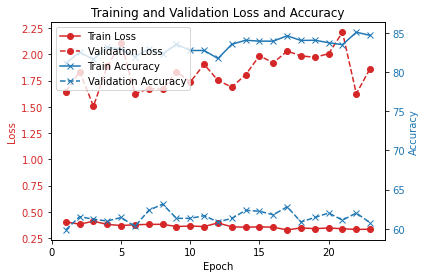

In [19]:
trainer = Train(train_loader, test_loader)

# 设置训练参数
epochs_num = 100
patience = 20
learning_rate = 0.001

# 开始训练模型
trained_model = trainer.train(model1, epochs_num, patience, learning_rate)

## 模型评价与改进

### 模型评价

In [20]:
trainer.model_info

{'max_accuracy': 63.13993174061434,
 'model_complexity': 34393,
 'convergence_speed': 3,
 'training_speed': 0.1069550347328186,
 'early_stop_epoch': 22,
 'generalization': 21.980978643453945}

### 数据增强

In [9]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.datasets import make_classification
from collections import Counter

# 假设我们有一个不平衡的简单数据集


# 使用字典定义sampling_strategy，仅对'high'类别进行过采样
sampling_strategy = {0: 500}

# 初始化SMOTE对象
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)


original_columns = X.columns

# 将 X 转换为 numpy 数组
X_np = X.values
y_encoded_np = y_encoded


X_res_np, y_res = smote.fit_resample(X_np, y_encoded_np)

# 将处理后的数据转换回 pandas DataFrame，并应用原始列名
X_res = pd.DataFrame(X_res_np, columns=original_columns)



In [10]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

X_train_tensor_res = torch.tensor(X_train_res.values, dtype=torch.float32)
X_test_tensor_res = torch.tensor(X_test_res.values, dtype=torch.float32)
y_train_tensor_res = torch.tensor(y_train_res, dtype=torch.long)
y_test_tensor_res = torch.tensor(y_test_res, dtype=torch.long)


train_dataset_res = CustomDataset(X_train_tensor_res, y_train_tensor_res)
test_dataset_res = CustomDataset(X_test_tensor_res, y_test_tensor_res)

# 使用DataLoader进行分批
train_loader_res = DataLoader(dataset=train_dataset_res, batch_size=32, shuffle=True)
test_loader_res = DataLoader(dataset=test_dataset_res, batch_size=32, shuffle=False)

### 模型改进

In [13]:
input_size_res = X_train_res.shape[1]
unique_labels_res = np.unique(y_train_res)
num_classes = len(unique_labels)
model2 = MLP(input_size_res, hidden_size, num_classes)

Epoch 1: Train Loss: 0.9526, Train Accuracy: 47.54%, Validation Loss: 0.8590, Validation Accuracy: 56.66%
Epoch 2: Train Loss: 0.8597, Train Accuracy: 53.91%, Validation Loss: 0.8189, Validation Accuracy: 57.82%
Epoch 3: Train Loss: 0.8274, Train Accuracy: 55.36%, Validation Loss: 0.7913, Validation Accuracy: 56.55%
Epoch 4: Train Loss: 0.7992, Train Accuracy: 56.90%, Validation Loss: 0.7691, Validation Accuracy: 57.72%
Epoch 5: Train Loss: 0.7778, Train Accuracy: 59.67%, Validation Loss: 0.7558, Validation Accuracy: 58.03%
Epoch 6: Train Loss: 0.7448, Train Accuracy: 61.79%, Validation Loss: 0.7455, Validation Accuracy: 61.31%
Epoch 7: Train Loss: 0.7193, Train Accuracy: 62.42%, Validation Loss: 0.7312, Validation Accuracy: 60.04%
Epoch 8: Train Loss: 0.6933, Train Accuracy: 65.99%, Validation Loss: 0.7263, Validation Accuracy: 61.95%
Epoch 9: Train Loss: 0.6628, Train Accuracy: 66.78%, Validation Loss: 0.7374, Validation Accuracy: 62.16%
Epoch 10: Train Loss: 0.6519, Train Accuracy: 

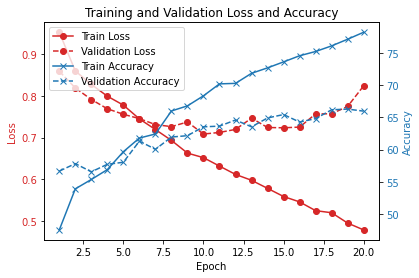

In [14]:
trainer_res = Train(train_loader_res, test_loader_res)

# 设置训练参数
epochs_num = 100
patience = 10
learning_rate = 0.001

# 开始训练模型
trained_model_res = trainer_res.train(model2, epochs_num, patience, learning_rate)

In [15]:
torch.save(trained_model_res, 'model2_meta.pth')

In [25]:
trainer_res.model_info

{'max_accuracy': 65.11627906976744,
 'model_complexity': 34393,
 'convergence_speed': 12,
 'training_speed': 0.10734267711639404,
 'early_stop_epoch': 21,
 'generalization': 13.372093023255815}

### 模型比较

In [8]:
def log_normalize(value, min_value, max_value):
    """ 对数变换并归一化一个值 """
    # 对数变换，避免对0取对数
    log_value = np.log(value + 1 - min_value)
    log_max = np.log(max_value + 1 - min_value)
    # 归一化
    return log_value / log_max

def min_max_normalize(value, min_value, max_value):
    """ 归一化一个值 """
    return (value - min_value) / (max_value - min_value)

In [9]:
def compare(*train_objects, model_names=[]):
    # 使用seaborn风格
    sns.set(style="whitegrid")

    # 设置雷达图的标签和角度
    labels = [
    'Accuracy (min-max)', 
    'Model Complexity (log)', 
    'Convergence Speed (min-max)', 
    'Training Speed (min-max)', 
    'Generalization (min-max)'
    ]
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # 检查model_names长度，如果不匹配，则使用默认名称
    if len(model_names) != len(train_objects):
        model_names = [f'Model {i+1}' for i in range(len(train_objects))]


    # 定义一组鲜艳的颜色
    bright_colors = [
        '#FF5733',  # 鲜红色
        '#33FF57',  # 亮绿色
        '#3357FF',  # 明亮的蓝色
        '#F933FF',  # 鲜紫色
        '#FFC733'   # 亮橙色
    ]

    # 使用这些颜色绘制雷达图
    for i, (train_obj, model_name) in enumerate(zip(train_objects, model_names)):
        stats = train_obj.model_info
        values = [
            min_max_normalize(stats['max_accuracy'], 0, 100),
            log_normalize(stats['model_complexity'], 0, 5000000),
            min_max_normalize(stats['convergence_speed'], 0, 50),
            min_max_normalize(stats['training_speed'], 0, 1),
            min_max_normalize(stats['generalization'], 0, 100)
        ]
        values += values[:1]

        # 指定颜色
        ax.plot(angles, values, label=model_name, linewidth=2, color=bright_colors[i % len(bright_colors)])
        ax.fill(angles, values, color=bright_colors[i % len(bright_colors)], alpha=0.25)



    # 设置雷达图的属性
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, color='grey', size=12)
    
    # 添加标题和图例
    plt.title('Model Comparison', size=20, color='black', y=1.1)

    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

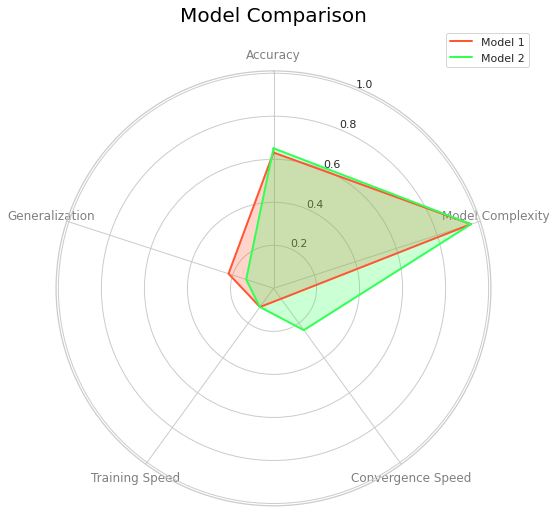

In [35]:
compare(trainer,trainer_res)

## Descript-Predction 

In [16]:
df2=df.loc[:,['merged_sales_category','name','words']]
df2.head()

,merged_sales_category,name,words
0,small,雅鹿正品男士加厚羽绒服中长款2023冬季新款中年冬装保暖外套,"['雅鹿', '正品', '男士', '加厚', '羽绒服', '中长款', '2023',..."
1,small,MOOSE KNUCKLES 3Q JKT 大毛领保暖运动羽绒服夹克男,"['MOOSE', ' ', 'KNUCKLES', ' ', '3Q', ' ', 'JK..."
2,small,中长款连帽男士羽绒服冬季2023新款潮牌加厚90白鸭绒男生冬装外套,"['中长款', '连帽', '男士', '羽绒服', '冬季', '2023', '新款',..."
3,small,羽绒服男士冬季2023新款美式潮牌立领工装白鸭绒情侣加厚保暖外套,"['羽绒服', '男士', '冬季', '2023', '新款', '美式', '潮牌', ..."
4,mid,森马集团棉致白鸭绒羽绒服男冬季2023新款轻薄加厚短款青少年外套,"['森马', '集团', '棉致', '白', '鸭绒', '羽绒服', '男', '冬季'..."


### 字符串处理

In [17]:
def load_stopwords(path):
    with open(path, 'r', encoding='utf-8') as file:
        stopwords = list([line.strip() for line in file])
    return stopwords

stopwords = load_stopwords("stopword.txt")

In [18]:
# 字符串处理

# 使用 TFIDF 处理 'title' 列
vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=jieba.lcut)
tfidf_matrix = vectorizer.fit_transform(df['words'])


# 将 TFIDF 矩阵转换为 DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# 合并原始数据集和 TFIDF DataFrame
df2 = pd.concat([df2, tfidf_df], axis=1)


X_des=df2.drop(['merged_sales_category','name','words'],axis=1)
y_des=df2['merged_sales_category']

label_encoder2 = LabelEncoder()

y_des = label_encoder2.fit_transform(y_des)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/zhaochen/.local/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpeime8syj' -> '/tmp/jieba.cache'
Loading model cost 0.785 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['##', 'lex', '~', '±', '÷', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '…', '′', '″', 'ⅲ', '∈', '∧', '∪', '─', '☆', '下', '不', '为什', '什', '今', '使', '元', '先', '却', '只', '吨', '唷', '啪', '喔', '天', '好', '後', '数', '日', '昉', '最', '末', '漫', '然', '特', '特别', '见', '设', '说', '达', '面', '麽', '０', '１', '２', '３', '５', 'ａ', 'ｂ

In [19]:
X_train_des, X_test_des, y_train_des, y_test_des = train_test_split(X_des, y_des, test_size=0.2, random_state=42)

X_train_tensor_des = torch.tensor(X_train_des.values, dtype=torch.float32)
X_test_tensor_des = torch.tensor(X_test_des.values, dtype=torch.float32)
y_train_tensor_des = torch.tensor(y_train_des, dtype=torch.long)
y_test_tensor_des = torch.tensor(y_test_des, dtype=torch.long)


train_dataset_des = CustomDataset(X_train_tensor_des, y_train_tensor_des)
test_dataset_des = CustomDataset(X_test_tensor_des, y_test_tensor_des)

# 使用DataLoader进行分批
train_loader_des = DataLoader(dataset=train_dataset_des, batch_size=32, shuffle=True)
test_loader_des= DataLoader(dataset=test_dataset_des, batch_size=32, shuffle=False)

### 机器学习模型对比

In [158]:

models = {
    "逻辑回归": LogisticRegression(),
    "决策树分类": DecisionTreeClassifier(random_state=42),
    "随机森林分类": RandomForestClassifier(random_state=42),
    "支持向量分类（SVM）": SVC(),
}

# 训练和评估模型
for name, model in models.items():
    model.fit(X_train_des, y_train_des)
    y_pred = model.predict(X_test_des)

    accuracy = accuracy_score(y_test_des, y_pred)

    print(f"{name} - 准确率: {accuracy:.2f}")


C:\CL17189\APPS\Python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


逻辑回归 - 准确率: 0.63
决策树分类 - 准确率: 0.56
随机森林分类 - 准确率: 0.62
支持向量分类（SVM） - 准确率: 0.65


### CNN

In [20]:

class CombinedCNNSalesPredictor(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(CombinedCNNSalesPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)  # 批量归一化层
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)  # 批量归一化层
        # 其他卷积层和BN层可以根据需要添加
        
        # 用虚拟输入数据计算卷积层的输出维度
        dummy_input = torch.zeros(1, input_size).unsqueeze(0)
        dummy_output = self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input))))))
        num_features = dummy_output.numel()


        # 定义一个全连接层，用于将卷积层的输出映射到类别输出
        self.fc1 = nn.Linear(num_features, num_classes)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout层

    def forward(self, x):
        x = x.unsqueeze(1)  # 增加一个维度来表示通道
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # 在全连接层之前应用Dropout
        x = self.fc1(x)
        return x


In [21]:
input_size = X_train_des.shape[1]  # 假设标题是18维，价格作为一个额外维度
num_classes =3  # 设定您的类别数量
model3 = CombinedCNNSalesPredictor(input_size, num_classes)


Epoch 1: Train Loss: 1.3231, Train Accuracy: 54.00%, Validation Loss: 0.8644, Validation Accuracy: 58.93%
Epoch 2: Train Loss: 0.7997, Train Accuracy: 61.56%, Validation Loss: 0.7387, Validation Accuracy: 64.51%
Epoch 3: Train Loss: 0.7457, Train Accuracy: 64.24%, Validation Loss: 0.7814, Validation Accuracy: 62.46%
Epoch 4: Train Loss: 0.6616, Train Accuracy: 68.08%, Validation Loss: 0.8244, Validation Accuracy: 58.13%
Epoch 5: Train Loss: 0.6415, Train Accuracy: 69.25%, Validation Loss: 0.7836, Validation Accuracy: 61.43%
Epoch 6: Train Loss: 0.6161, Train Accuracy: 70.61%, Validation Loss: 0.8033, Validation Accuracy: 59.84%
Epoch 7: Train Loss: 0.5937, Train Accuracy: 71.61%, Validation Loss: 0.8115, Validation Accuracy: 62.57%
Epoch 8: Train Loss: 0.5668, Train Accuracy: 72.52%, Validation Loss: 0.8091, Validation Accuracy: 61.32%
Epoch 9: Train Loss: 0.5494, Train Accuracy: 73.66%, Validation Loss: 0.8194, Validation Accuracy: 61.43%
Epoch 10: Train Loss: 0.5369, Train Accuracy: 

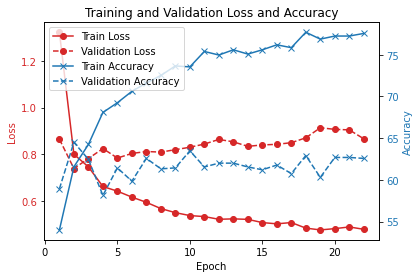

In [22]:
trainer_des = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 20
learning_rate = 0.001

# 开始训练模型
trained_model_res = trainer_des.train(model3, epochs_num, patience, learning_rate)

### LTSM

In [23]:
class LSTMSalesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMSalesPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # 全连接层，预测销售类别
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, titles):
        if titles.dim() == 2:
            titles = titles.unsqueeze(1)  # 现在形状为 [batch_size, 1, feature_number]

        # LSTM层的初始隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)
        c0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)

        # 前向传播LSTM
        out, _ = self.lstm(titles, (h0, c0))

        # 选择LSTM输出的最后一个时间步
        out = out[:, -1, :]

        # 全连接层
        out = self.fc(out)
        return out


In [24]:
# 创建模型实例
hidden_dim = 128  # LSTM隐藏层的维度
num_layers = 2  # LSTM层数
num_classes = 3  # 您的类别数量

model4 = LSTMSalesPredictor(input_size, hidden_dim, num_layers, num_classes)

Epoch 1: Train Loss: 0.8792, Train Accuracy: 51.58%, Validation Loss: 0.8029, Validation Accuracy: 52.10%
Epoch 2: Train Loss: 0.7863, Train Accuracy: 56.07%, Validation Loss: 0.7643, Validation Accuracy: 57.45%
Epoch 3: Train Loss: 0.6887, Train Accuracy: 66.54%, Validation Loss: 0.7252, Validation Accuracy: 66.33%
Epoch 4: Train Loss: 0.6173, Train Accuracy: 71.27%, Validation Loss: 0.7332, Validation Accuracy: 65.42%
Epoch 5: Train Loss: 0.5600, Train Accuracy: 74.79%, Validation Loss: 0.7651, Validation Accuracy: 63.94%
Epoch 6: Train Loss: 0.5205, Train Accuracy: 75.62%, Validation Loss: 0.7827, Validation Accuracy: 63.82%
Epoch 7: Train Loss: 0.4813, Train Accuracy: 78.01%, Validation Loss: 0.8269, Validation Accuracy: 63.14%
Epoch 8: Train Loss: 0.4561, Train Accuracy: 78.92%, Validation Loss: 0.8534, Validation Accuracy: 63.25%
Epoch 9: Train Loss: 0.4311, Train Accuracy: 80.34%, Validation Loss: 0.8838, Validation Accuracy: 61.55%
Epoch 10: Train Loss: 0.4119, Train Accuracy: 

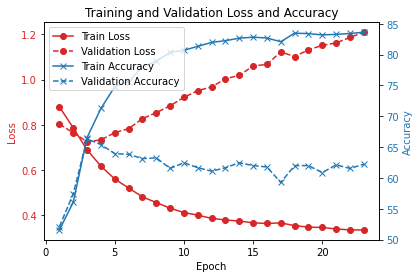

In [33]:
trainer_des_LTSM = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 20
learning_rate = 0.001

# 开始训练模型
trained_model_LTSM = trainer_des_LTSM.train(model4, epochs_num, patience, learning_rate)

### Transformer

In [25]:
class TransformerSalesPredictor(nn.Module):
    def __init__(self, title_dim, num_classes, num_heads, num_layers, dropout=0.1):
        super(TransformerSalesPredictor, self).__init__()

        # Transformer的配置参数
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        # Transformer编码器层
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=title_dim, 
            nhead=num_heads, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, 
            num_layers=num_layers
        )

        # 最后的分类器
        self.classifier = nn.Linear(title_dim, num_classes)

    def forward(self, titles):
        # 通过Transformer编码器
        titles = titles.unsqueeze(0)
        transformer_out = self.transformer_encoder(titles)

        # 选择Transformer输出的最后一个时间步
        transformer_out = transformer_out.mean(dim=0)


        # 分类器
        output = self.classifier(transformer_out)
        return output

In [26]:
# 创建模型实例
title_dim= X_des.shape[1] # 标题向量的维度
num_classes = 3  # 您的类别数量
num_heads =5  # Transformer头的数量
num_layers =2   # Transformer编码器层数


model5 = TransformerSalesPredictor(title_dim, num_classes, num_heads, num_layers)

Epoch 1: Train Loss: 1.1565, Train Accuracy: 48.76%, Validation Loss: 0.8638, Validation Accuracy: 52.10%
Epoch 2: Train Loss: 0.8201, Train Accuracy: 57.35%, Validation Loss: 0.7838, Validation Accuracy: 60.64%
Epoch 3: Train Loss: 0.6767, Train Accuracy: 70.04%, Validation Loss: 0.8074, Validation Accuracy: 62.91%
Epoch 4: Train Loss: 0.6119, Train Accuracy: 72.77%, Validation Loss: 0.8235, Validation Accuracy: 61.66%
Epoch 5: Train Loss: 0.5963, Train Accuracy: 74.57%, Validation Loss: 0.8414, Validation Accuracy: 59.84%
Epoch 6: Train Loss: 0.5597, Train Accuracy: 75.90%, Validation Loss: 0.9180, Validation Accuracy: 62.12%
Epoch 7: Train Loss: 0.5340, Train Accuracy: 76.90%, Validation Loss: 1.1001, Validation Accuracy: 63.14%
Epoch 8: Train Loss: 0.5242, Train Accuracy: 77.27%, Validation Loss: 0.8996, Validation Accuracy: 59.84%
Epoch 9: Train Loss: 0.4974, Train Accuracy: 78.55%, Validation Loss: 1.0873, Validation Accuracy: 60.30%
Epoch 10: Train Loss: 0.5133, Train Accuracy: 

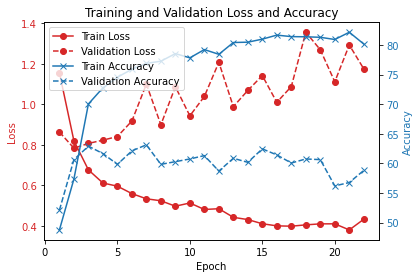

In [26]:
trainer_des_Trans = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 20
learning_rate = 0.001

# 开始训练模型
trained_model_Trans = trainer_des_Trans.train(model5, epochs_num, patience, learning_rate)

#### Bert

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2['name'], df2['merged_sales_category'], test_size=0.2, random_state=42)

# 初始化BERT的tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 为了适应BERT的输入，创建Dataset类
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        # 对文本进行编码
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# 将标签转换为数字
label_dict = {label: index for index, label in enumerate(y_train.unique())}
y_train = y_train.map(label_dict)
y_test = y_test.map(label_dict)

# 创建Dataset
train_dataset = TextDataset(X_train.to_numpy(), y_train.to_numpy(), tokenizer)
test_dataset = TextDataset(X_test.to_numpy(), y_test.to_numpy(), tokenizer)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 现在我们来定义BERT模型用于序列分类
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=len(label_dict))


## 模型评价与改进

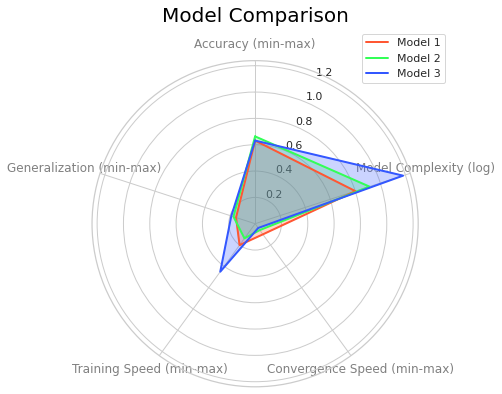

In [40]:
compare(trainer_des,trainer_des_LTSM,trainer_des_Trans)

### 数据增强

In [27]:

# 假设您的同义词词典文件名为'synonyms.json'
with open('synonyms_expanded_narrow.json', 'r', encoding='utf-8') as file:
    synonym_dict = json.load(file)

print(synonym_dict['冬季'])

print(synonym_dict['简约'])


['冬']
['简单']


In [28]:
df3=df[['merged_sales_category','name','words']]

df3['words']=df3['words'].apply(ast.literal_eval)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df3

,merged_sales_category,name,words
0,small,雅鹿正品男士加厚羽绒服中长款2023冬季新款中年冬装保暖外套,"[雅鹿, 正品, 男士, 加厚, 羽绒服, 中长款, 2023, 冬季, 新款, 中年, 冬..."
1,small,MOOSE KNUCKLES 3Q JKT 大毛领保暖运动羽绒服夹克男,"[MOOSE, , KNUCKLES, , 3Q, , JKT, , 大, 毛领, ..."
2,small,中长款连帽男士羽绒服冬季2023新款潮牌加厚90白鸭绒男生冬装外套,"[中长款, 连帽, 男士, 羽绒服, 冬季, 2023, 新款, 潮牌, 加厚, 90, 白..."
3,small,羽绒服男士冬季2023新款美式潮牌立领工装白鸭绒情侣加厚保暖外套,"[羽绒服, 男士, 冬季, 2023, 新款, 美式, 潮牌, 立领, 工装, 白, 鸭绒,..."
4,mid,森马集团棉致白鸭绒羽绒服男冬季2023新款轻薄加厚短款青少年外套,"[森马, 集团, 棉致, 白, 鸭绒, 羽绒服, 男, 冬季, 2023, 新款, 轻薄, ..."
...,...,...,...
4389,mid,鸭鸭羽绒服女款2023年新款中老年妈妈装短款简约宽松秋冬外套W,"[鸭, 鸭, 羽绒服, 女款, 2023, 年, 新款, 中老年, 妈妈, 装, 短款, 简..."
4390,mid,道木熙95%白鸭绒~短款羽绒服女2023新款轻便休闲宽松冬季保暖外套,"[道, 木熙, 95%, 白, 鸭绒, ~, 短款, 羽绒服, 女, 2023, 新款, 轻..."
4391,small,陈意涵明星同款鸭鸭羽绒服女2023短款卫衣两件套马海毛格子外套C,"[陈, 意涵, 明星, 同款, 鸭, 鸭, 羽绒服, 女, 2023, 短款, 卫衣, 两件..."
4392,mid,「叙境」杏色鸭绒羽绒服女2023冬季新款高级感宽松小个子加厚外套,"[「, 叙境, 杏色, 鸭绒, 羽绒服, 女, 2023, 冬季, 新款, 高级, 感, 宽..."


In [29]:

# 筛选sales=='high'的行
high_sales_df = df3.query("merged_sales_category=='high'")

other_df=df3.query("merged_sales_category!='high'")

# 准备增强数据
def augment_row(high_sales_df, n_aim, synonym_dict, replacement_ratio=0.4):
    augmented_rows = []

    while len(augmented_rows) < n_aim:
        for _, row in high_sales_df.iterrows():
            words = row['words']  # 分词结果

            new_words = words.copy()

            # 计算要替换的词汇数量
            num_replacements = int(len(words) * replacement_ratio)
            words_to_replace = random.sample(words, min(num_replacements, len(words)))

            # 对选中的词汇进行替换
            for word in words_to_replace:
                if word in synonym_dict:
                    synonym = random.choice(synonym_dict[word])
                    new_words = [synonym if w == word else w for w in new_words]

            new_title = ''.join(new_words)
            augmented_rows.append([row['merged_sales_category'],new_title,new_words ])

            if len(augmented_rows) >= n_aim:
                break

    return augmented_rows



In [30]:
# 将增强的数据添加到原始DataFrame
augmented_df_high = pd.DataFrame(augment_row(high_sales_df,600,synonym_dict), columns=['merged_sales_category','name','words'])
df3 = pd.concat([other_df, augmented_df_high], ignore_index=True)
df3.head()

,merged_sales_category,name,words
0,small,雅鹿正品男士加厚羽绒服中长款2023冬季新款中年冬装保暖外套,"[雅鹿, 正品, 男士, 加厚, 羽绒服, 中长款, 2023, 冬季, 新款, 中年, 冬..."
1,small,MOOSE KNUCKLES 3Q JKT 大毛领保暖运动羽绒服夹克男,"[MOOSE, , KNUCKLES, , 3Q, , JKT, , 大, 毛领, ..."
2,small,中长款连帽男士羽绒服冬季2023新款潮牌加厚90白鸭绒男生冬装外套,"[中长款, 连帽, 男士, 羽绒服, 冬季, 2023, 新款, 潮牌, 加厚, 90, 白..."
3,small,羽绒服男士冬季2023新款美式潮牌立领工装白鸭绒情侣加厚保暖外套,"[羽绒服, 男士, 冬季, 2023, 新款, 美式, 潮牌, 立领, 工装, 白, 鸭绒,..."
4,mid,森马集团棉致白鸭绒羽绒服男冬季2023新款轻薄加厚短款青少年外套,"[森马, 集团, 棉致, 白, 鸭绒, 羽绒服, 男, 冬季, 2023, 新款, 轻薄, ..."


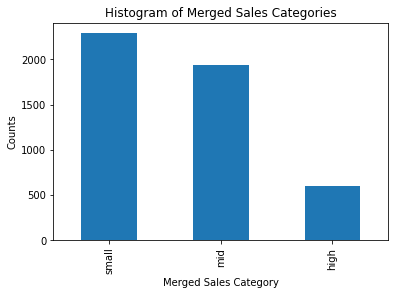

In [31]:
sorted_data3 = df3['merged_sales_category'].value_counts().sort_index()

# 绘制排序后的直方图

df3['merged_sales_category'].value_counts().plot(kind='bar')
plt.xlabel('Merged Sales Category')
plt.ylabel('Counts')
plt.title('Histogram of Merged Sales Categories')

plt.show()

### 字符串

In [32]:
# 字符串处理

# 使用 TFIDF 处理 'title' 列

tfidf_matrix_aug = vectorizer.fit_transform(df3['name'])


# 将 TFIDF 矩阵转换为 DataFrame
tfidf_df_aug = pd.DataFrame(tfidf_matrix_aug.toarray(), columns=vectorizer.get_feature_names())

# 合并原始数据集和 TFIDF DataFrame
df3 = pd.concat([df3, tfidf_df_aug], axis=1)


X_des_aug=df3.drop(['merged_sales_category','name','words'],axis=1)
y_des_aug=df3['merged_sales_category']

label_encoder3 = LabelEncoder()

y_des_aug = label_encoder3.fit_transform(y_des_aug)

In [ ]:
df3

In [33]:
X_train_des_aug, X_test_des_aug, y_train_des_aug, y_test_des_aug = train_test_split(X_des_aug, y_des_aug, test_size=0.2, random_state=42)

X_train_tensor_des_aug = torch.tensor(X_train_des_aug.values, dtype=torch.float32)
X_test_tensor_des_aug = torch.tensor(X_test_des_aug.values, dtype=torch.float32)
y_train_tensor_des_aug = torch.tensor(y_train_des_aug, dtype=torch.long)
y_test_tensor_des_aug = torch.tensor(y_test_des_aug, dtype=torch.long)


train_dataset_des_aug = CustomDataset(X_train_tensor_des_aug, y_train_tensor_des_aug)
test_dataset_des_aug = CustomDataset(X_test_tensor_des_aug, y_test_tensor_des_aug)

# 使用DataLoader进行分批
train_loader_des_aug = DataLoader(dataset=train_dataset_des_aug, batch_size=32, shuffle=True)
test_loader_des_aug= DataLoader(dataset=test_dataset_des_aug, batch_size=32, shuffle=False)

(4830, 4870)

###  模型改进

Epoch 1: Train Loss: 1.1778, Train Accuracy: 55.93%, Validation Loss: 0.9042, Validation Accuracy: 55.29%
Epoch 2: Train Loss: 0.8356, Train Accuracy: 61.93%, Validation Loss: 0.7930, Validation Accuracy: 60.52%
Epoch 3: Train Loss: 0.7193, Train Accuracy: 64.98%, Validation Loss: 0.7689, Validation Accuracy: 60.41%
Epoch 4: Train Loss: 0.6837, Train Accuracy: 68.25%, Validation Loss: 0.7913, Validation Accuracy: 63.25%
Epoch 5: Train Loss: 0.6143, Train Accuracy: 69.96%, Validation Loss: 0.8400, Validation Accuracy: 59.73%
Epoch 6: Train Loss: 0.5868, Train Accuracy: 72.26%, Validation Loss: 0.7869, Validation Accuracy: 61.21%
Epoch 7: Train Loss: 0.5588, Train Accuracy: 73.91%, Validation Loss: 0.8470, Validation Accuracy: 62.46%
Epoch 8: Train Loss: 0.5622, Train Accuracy: 72.75%, Validation Loss: 0.8051, Validation Accuracy: 61.55%
Epoch 9: Train Loss: 0.5432, Train Accuracy: 74.62%, Validation Loss: 0.8183, Validation Accuracy: 61.77%
Epoch 10: Train Loss: 0.5363, Train Accuracy: 

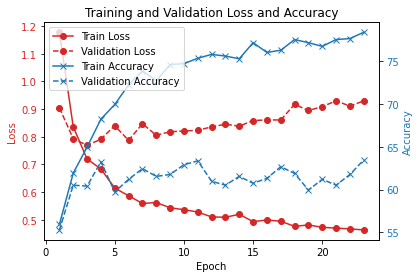

In [34]:
input_size = X_train_des.shape[1]  # 假设标题是18维，价格作为一个额外维度
num_classes =3  # 设定您的类别数量
model3 = CombinedCNNSalesPredictor(input_size, num_classes)
trainer_des = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 20
learning_rate = 0.001

# 开始训练模型
trained_model_res = trainer_des.train(model3, epochs_num, patience, learning_rate)

Epoch 1: Train Loss: 0.8771, Train Accuracy: 52.18%, Validation Loss: 0.8062, Validation Accuracy: 52.10%
Epoch 2: Train Loss: 0.7933, Train Accuracy: 53.46%, Validation Loss: 0.7731, Validation Accuracy: 60.75%
Epoch 3: Train Loss: 0.6999, Train Accuracy: 66.15%, Validation Loss: 0.7276, Validation Accuracy: 63.14%
Epoch 4: Train Loss: 0.6064, Train Accuracy: 71.29%, Validation Loss: 0.7498, Validation Accuracy: 64.16%
Epoch 5: Train Loss: 0.5439, Train Accuracy: 75.59%, Validation Loss: 0.7813, Validation Accuracy: 63.14%
Epoch 6: Train Loss: 0.4975, Train Accuracy: 77.24%, Validation Loss: 0.8081, Validation Accuracy: 64.05%
Epoch 6: Early stopping!


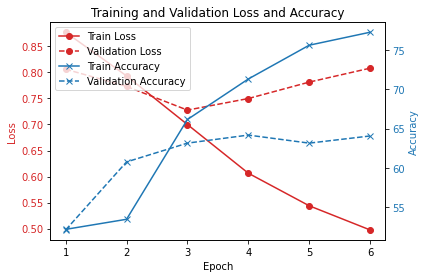

In [43]:
# 创建模型实例
hidden_dim = 128  # LSTM隐藏层的维度
num_layers = 2  # LSTM层数
num_classes = 3  # 您的类别数量

model4 = LSTMSalesPredictor(input_size, hidden_dim, num_layers, num_classes)
trainer_des_LTSM = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 3
learning_rate = 0.001

# 开始训练模型
trained_model_LTSM = trainer_des_LTSM.train(model4, epochs_num, patience, learning_rate)

Epoch 1: Train Loss: 1.3408, Train Accuracy: 46.17%, Validation Loss: 0.8500, Validation Accuracy: 52.10%
Epoch 2: Train Loss: 0.8604, Train Accuracy: 53.26%, Validation Loss: 0.8383, Validation Accuracy: 48.81%
Epoch 3: Train Loss: 0.7439, Train Accuracy: 66.23%, Validation Loss: 0.8314, Validation Accuracy: 62.80%
Epoch 4: Train Loss: 0.6505, Train Accuracy: 71.52%, Validation Loss: 0.9835, Validation Accuracy: 59.16%
Epoch 5: Train Loss: 0.6070, Train Accuracy: 74.77%, Validation Loss: 0.9035, Validation Accuracy: 62.68%
Epoch 6: Train Loss: 0.5803, Train Accuracy: 75.42%, Validation Loss: 0.9382, Validation Accuracy: 59.04%
Epoch 6: Early stopping!


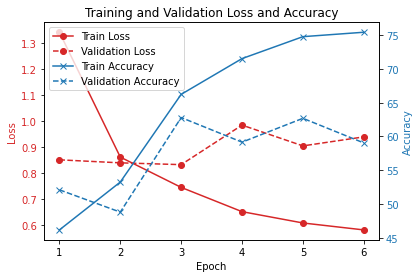

In [42]:
# 创建模型实例
title_dim= input_size  # 标题向量的维度
num_classes = 3  # 您的类别数量
num_heads =5 # Transformer头的数量
num_layers =2   # Transformer编码器层数


model5 = TransformerSalesPredictor(title_dim ,num_classes, num_heads, num_layers)
trainer_des_Trans_new = Train(train_loader_des, test_loader_des)

# 设置训练参数
epochs_num = 100
patience = 3
learning_rate = 0.001

# 开始训练模型
trained_model_Trans_new = trainer_des_Trans_new.train(model5, epochs_num, patience, learning_rate)

In [44]:
torch.save(trained_model_LTSM, 'model_Descrip_aug.pth')

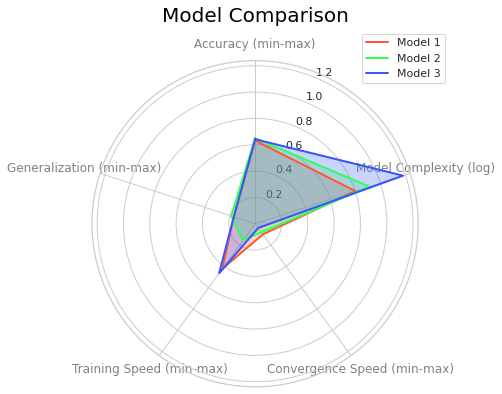

In [61]:
compare(trainer_des,trainer_des_LTSM,trainer_des_Trans_new)

2155